<a href="https://colab.research.google.com/github/YasudaKaito/pytorch_book_akaishi/blob/main/ch10_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. NNの多層化
2. 最適化関数の改善
3. 過学習対策

# 10.2 多層化

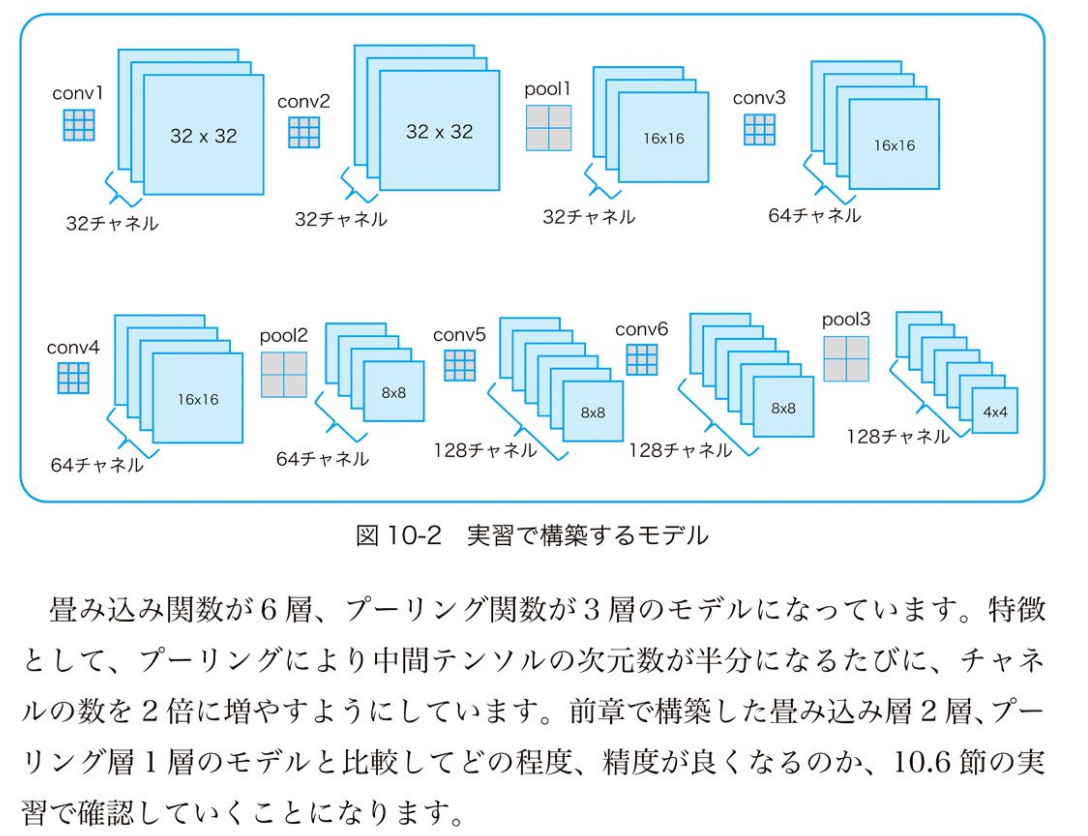

# 10.3 最適化関数の改善

- Momentum
    - SGDが直近の勾配しかパラメータ更新に利用しないのに対し、
    - 過去の勾配も記憶して、その分もパラメータを一定比率で減らしつつパラメータ更新に利用
- Adam
    - 多数のアルゴリズムのいいところを取り入れたもの
    

# 10.4 過学習対策

## ドロップアウト
- レイヤー関数の間に挟む
- ランダムにテンソルの要素を選び、対象に選ばれた要素の出力値を0とする
- 学習ごとにランダムに異なるテンソル要素を選ぶ
- 予測フェーズではドロップアウトの状態をなくしてすべての要素が参加した形で予測する


In [10]:
# 必要ライブラリの導入
# ローカル Anaconda 環境では torch torchvision torchaudio をインストール済み
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install japanize_matplotlib
!pip install torchinfo
!pip install torchviz
!pip install tqdm

  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.2-py3-none-any.whl (78 kB)


In [1]:
# 必要ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [11]:
# PyTorch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchviz import make_dot

In [12]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [13]:
# ドロップアウトの実験
torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [14]:
dropout = nn.Dropout(0.5)

# 訓練フェーズの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測フェーズの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


- 0でない要素は、2倍になっている
    - 「ドロップアウト比率をpとしたとき、出力は 1/(1-p) 倍した値が戻される」
    - 入力値全体の平均がドロップアウト前後で変わらないようにする工夫
    - 今回は p=0.5 のため、2倍

## バッチ正規化

以下、G検定の緑本の内容をまとめた

- 標準化=平均を引いて標準偏差で割る
- 各層におけるミニバッチごとに標準化を行う
- データ分布の偏りをなくし、正規分布に近くなるようにデータを整える
- 通常、線形変換と非線形変換の間に適用する
    - 例：
        - 全結合層と活性化層
        - 畳み込み層と活性化層


In [16]:
import sys
sys.path.append("../../lib/")

In [28]:
# モデル定義
class CNN_v2(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
        self.conv2 = nn.Conv2d(32, 32, 3, padding="same")
        self.maxpool = nn.MaxPool2d((2, 2))
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 64, 3, padding="same")
        self.conv5 = nn.Conv2d(64, 128, 3, padding="same")
        self.conv6 = nn.Conv2d(128, 128, 3, padding="same")
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # maxpool を3回かけるので画像の辺の長さが 32 -> 16 -> 8 -> 4 になる
        # チャネル数128 のため、flatten すると4*4*128の特徴量となる
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [19]:
# GPUチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [29]:
n_output = 10

torch_seed()

lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [30]:
# Transformsの定義
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [31]:
# データ取得用関数 Dataset
data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
print(train_set.data.shape)
print(test_set.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [33]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
# 1エポックあたり 50000 / 100 = 500回まわる
train_loader = DataLoader(train_set,
    batch_size = batch_size, shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,
    batch_size = batch_size, shuffle = False)

In [34]:
num_epochs = 50
history = fit(
    net,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.30313 acc: 0.10000 val_loss: 2.30278, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 2.30268 acc: 0.10000 val_loss: 2.30252, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 2.30248 acc: 0.10000 val_loss: 2.30234, val_acc: 0.10000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 2.30228 acc: 0.10836 val_loss: 2.30210, val_acc: 0.10170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 2.30196 acc: 0.13022 val_loss: 2.30164, val_acc: 0.17490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 2.30118 acc: 0.16742 val_loss: 2.30031, val_acc: 0.19150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 2.29810 acc: 0.18544 val_loss: 2.29354, val_acc: 0.21830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 2.24523 acc: 0.21884 val_loss: 2.09653, val_acc: 0.23900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 2.01606 acc: 0.26142 val_loss: 1.94553, val_acc: 0.29310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.90653 acc: 0.31254 val_loss: 1.89855, val_acc: 0.31160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.79606 acc: 0.35152 val_loss: 1.70006, val_acc: 0.38690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.69672 acc: 0.38304 val_loss: 1.62491, val_acc: 0.41250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.62868 acc: 0.40612 val_loss: 1.56085, val_acc: 0.42820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.57421 acc: 0.42192 val_loss: 1.62305, val_acc: 0.41490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.53024 acc: 0.43724 val_loss: 1.51224, val_acc: 0.44010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.48161 acc: 0.45966 val_loss: 1.44050, val_acc: 0.47170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.44079 acc: 0.47416 val_loss: 1.39906, val_acc: 0.48700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.39832 acc: 0.49372 val_loss: 1.42527, val_acc: 0.48600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.35321 acc: 0.51364 val_loss: 1.32939, val_acc: 0.51890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.30886 acc: 0.53304 val_loss: 1.29961, val_acc: 0.53000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.25752 acc: 0.54986 val_loss: 1.23487, val_acc: 0.55510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.21618 acc: 0.56676 val_loss: 1.21018, val_acc: 0.56500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.17330 acc: 0.58194 val_loss: 1.18986, val_acc: 0.57740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.14091 acc: 0.59538 val_loss: 1.16094, val_acc: 0.58740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.09688 acc: 0.61068 val_loss: 1.12524, val_acc: 0.59830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.05992 acc: 0.62538 val_loss: 1.09906, val_acc: 0.61160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.02113 acc: 0.64076 val_loss: 1.12196, val_acc: 0.60480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.98496 acc: 0.65210 val_loss: 1.05901, val_acc: 0.63130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.95476 acc: 0.66510 val_loss: 1.00723, val_acc: 0.64770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.91636 acc: 0.68006 val_loss: 0.97588, val_acc: 0.65480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.88503 acc: 0.69198 val_loss: 0.96616, val_acc: 0.66100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.85720 acc: 0.69934 val_loss: 0.93883, val_acc: 0.67220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.82295 acc: 0.71302 val_loss: 0.98840, val_acc: 0.65920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.79508 acc: 0.72222 val_loss: 0.92477, val_acc: 0.68110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.76115 acc: 0.73472 val_loss: 0.94078, val_acc: 0.67590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.73436 acc: 0.74318 val_loss: 0.92376, val_acc: 0.67990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.70560 acc: 0.75352 val_loss: 0.92363, val_acc: 0.69050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.67440 acc: 0.76502 val_loss: 0.92475, val_acc: 0.69030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.64148 acc: 0.77666 val_loss: 0.92072, val_acc: 0.69770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.61806 acc: 0.78292 val_loss: 0.90788, val_acc: 0.69470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.58835 acc: 0.79558 val_loss: 0.96307, val_acc: 0.68980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.55860 acc: 0.80436 val_loss: 0.93284, val_acc: 0.70370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.52751 acc: 0.81414 val_loss: 0.92239, val_acc: 0.70310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.49696 acc: 0.82678 val_loss: 0.91758, val_acc: 0.71350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.47025 acc: 0.83416 val_loss: 1.02182, val_acc: 0.68810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43809 acc: 0.84674 val_loss: 0.98088, val_acc: 0.70580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.40844 acc: 0.85578 val_loss: 0.97408, val_acc: 0.70310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.37457 acc: 0.86984 val_loss: 1.03529, val_acc: 0.70280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.34592 acc: 0.87816 val_loss: 1.07459, val_acc: 0.70000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.31687 acc: 0.88950 val_loss: 1.10268, val_acc: 0.69770


初期状態: 損失: 2.30278 精度: 0.10000
最終状態: 損失: 1.10268 精度: 0.69770


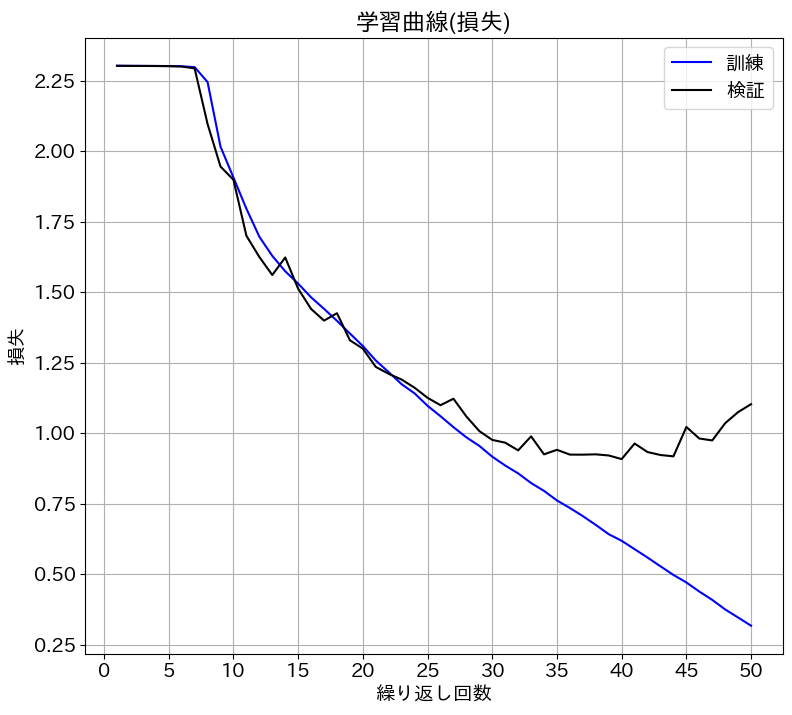

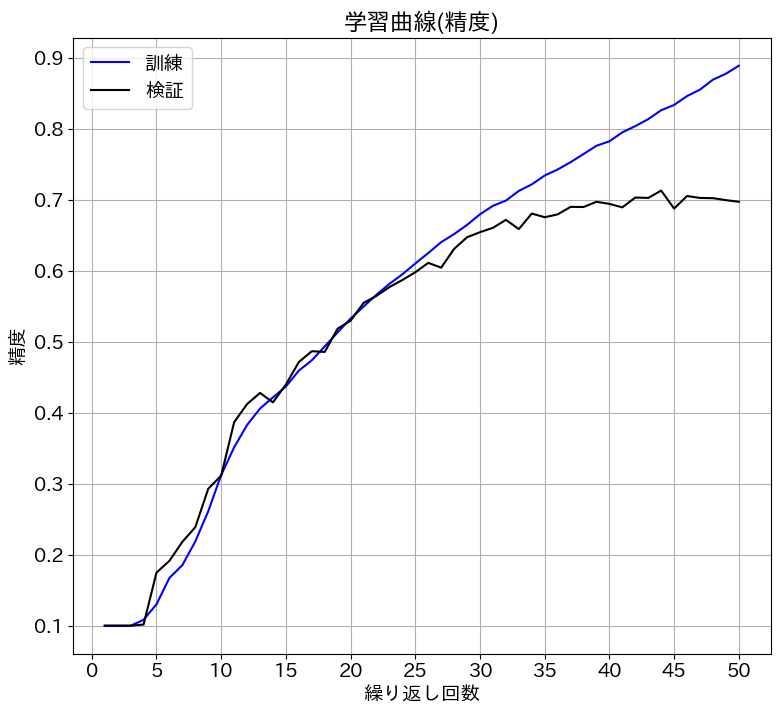

In [35]:
evaluate_history(history)

# momentum

In [36]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にmomentumを指定
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

In [37]:
# 学習

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 2.28224 acc: 0.12338 val_loss: 2.03918, val_acc: 0.25470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 1.79483 acc: 0.33914 val_loss: 1.51860, val_acc: 0.42670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 1.40626 acc: 0.48380 val_loss: 1.28180, val_acc: 0.53900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 1.16481 acc: 0.58244 val_loss: 1.10601, val_acc: 0.60580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.97358 acc: 0.65324 val_loss: 0.89311, val_acc: 0.68260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.82254 acc: 0.70862 val_loss: 0.83675, val_acc: 0.70880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.68399 acc: 0.76024 val_loss: 0.76997, val_acc: 0.73210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.57784 acc: 0.79748 val_loss: 0.73536, val_acc: 0.75170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.49195 acc: 0.82640 val_loss: 0.74564, val_acc: 0.75000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.41731 acc: 0.85366 val_loss: 0.73487, val_acc: 0.76050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.33706 acc: 0.88080 val_loss: 0.77586, val_acc: 0.75840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.27906 acc: 0.90032 val_loss: 0.82864, val_acc: 0.75960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.22604 acc: 0.92014 val_loss: 0.87640, val_acc: 0.76700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.18875 acc: 0.93158 val_loss: 0.96552, val_acc: 0.75710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.16156 acc: 0.94210 val_loss: 1.05745, val_acc: 0.76480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.13690 acc: 0.95234 val_loss: 1.12108, val_acc: 0.76760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.11911 acc: 0.95804 val_loss: 1.13724, val_acc: 0.76190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.10500 acc: 0.96364 val_loss: 1.22925, val_acc: 0.76170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.09855 acc: 0.96584 val_loss: 1.26664, val_acc: 0.76720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.08948 acc: 0.96890 val_loss: 1.26835, val_acc: 0.75560


初期状態: 損失: 2.03918 精度: 0.25470
最終状態: 損失: 1.26835 精度: 0.75560


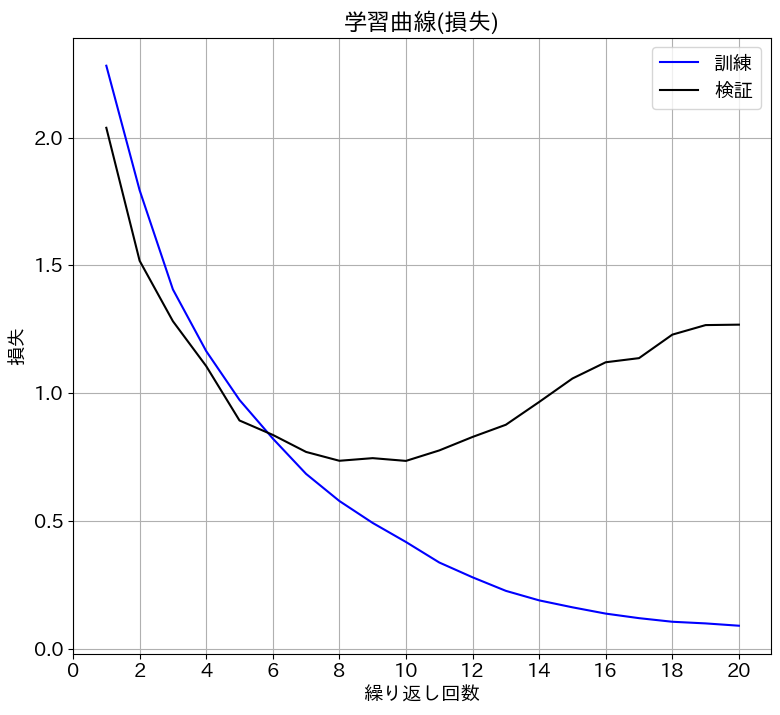

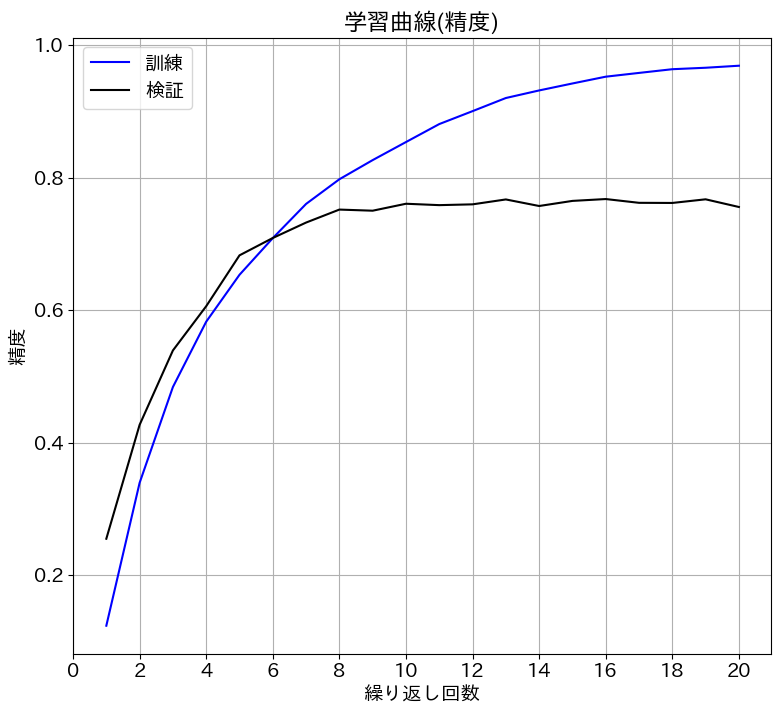

In [38]:
evaluate_history(history2)

# Adam

In [39]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
# 最適化関数にAdamを指定
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [40]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [41]:
# 学習
num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/20], loss: 1.58306 acc: 0.41998 val_loss: 1.23594, val_acc: 0.54480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/20], loss: 1.07504 acc: 0.61442 val_loss: 0.97186, val_acc: 0.65770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.85604 acc: 0.69740 val_loss: 0.86878, val_acc: 0.70120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.70365 acc: 0.75200 val_loss: 0.80015, val_acc: 0.72630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.59507 acc: 0.79010 val_loss: 0.72078, val_acc: 0.74930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.50935 acc: 0.82098 val_loss: 0.70587, val_acc: 0.76290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.42767 acc: 0.84960 val_loss: 0.70752, val_acc: 0.76480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.35541 acc: 0.87350 val_loss: 0.74078, val_acc: 0.76590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.29156 acc: 0.89662 val_loss: 0.79302, val_acc: 0.76030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.23607 acc: 0.91634 val_loss: 0.85794, val_acc: 0.76580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.19160 acc: 0.93172 val_loss: 0.94176, val_acc: 0.76680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.16124 acc: 0.94214 val_loss: 1.04949, val_acc: 0.74840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.13895 acc: 0.95078 val_loss: 1.07906, val_acc: 0.75830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.12730 acc: 0.95452 val_loss: 1.18578, val_acc: 0.76040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.11210 acc: 0.96050 val_loss: 1.24014, val_acc: 0.76390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.10916 acc: 0.96050 val_loss: 1.23498, val_acc: 0.76040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.10269 acc: 0.96460 val_loss: 1.29743, val_acc: 0.74770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.08284 acc: 0.97122 val_loss: 1.34311, val_acc: 0.76380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.08892 acc: 0.96880 val_loss: 1.34658, val_acc: 0.76880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.08162 acc: 0.97120 val_loss: 1.49652, val_acc: 0.75400


初期状態: 損失: 1.23594 精度: 0.54480
最終状態: 損失: 1.49652 精度: 0.75400


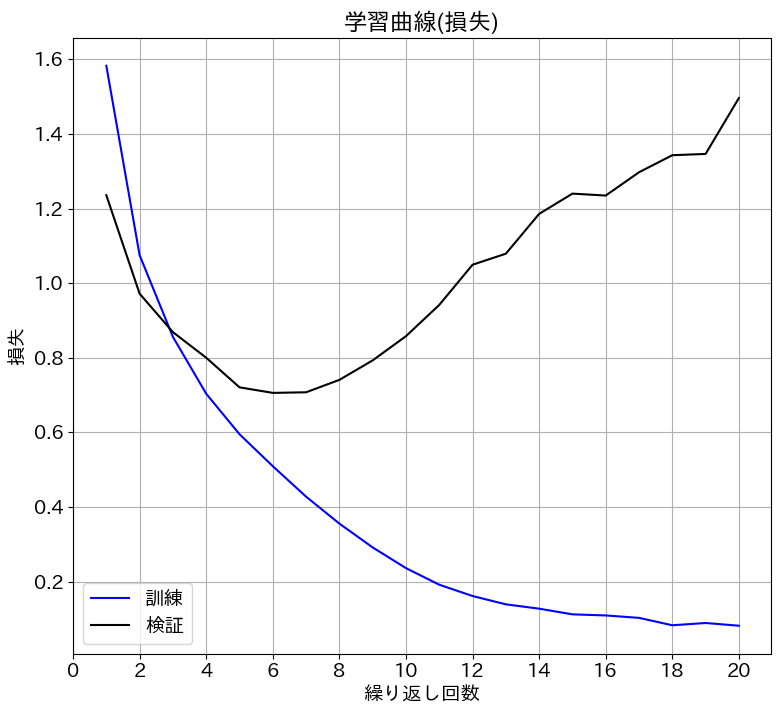

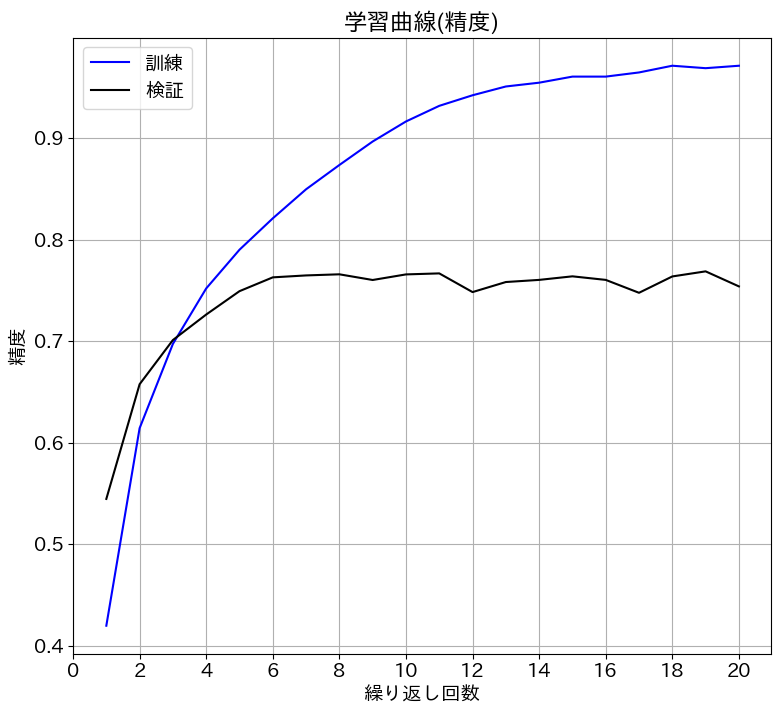

In [42]:
evaluate_history(history3)

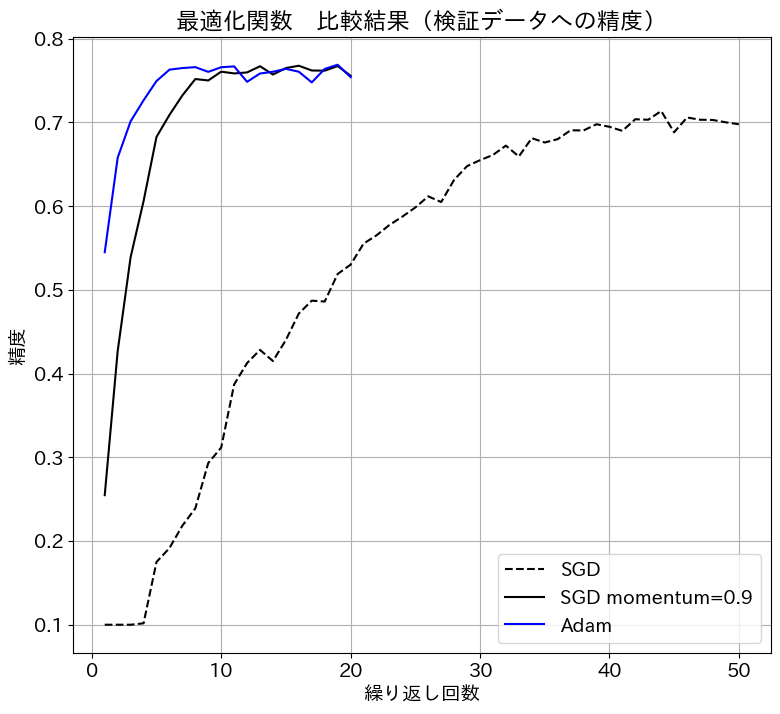

In [43]:
# 結果の比較(検証データへの精度=正解率)
plt.figure(figsize=(9,8))
plt.plot(history[:,0], history[:,4], label='SGD', c='k',ls='dashed' )
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9', c='k')
plt.plot(history3[:,0], history3[:,4], label='Adam', c='b')
plt.title('最適化関数　比較結果（検証データへの精度）')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.legend()
plt.show()

# 10.8 ドロップアウト

In [44]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
        self.conv2 = nn.Conv2d(32, 32, 3, padding="same")
        self.maxpool = nn.MaxPool2d((2, 2))
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 64, 3, padding="same")
        self.conv5 = nn.Conv2d(64, 128, 3, padding="same")
        self.conv6 = nn.Conv2d(128, 128, 3, padding="same")
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # maxpool を3回かけるので画像の辺の長さが 32 -> 16 -> 8 -> 4 になる
        # チャネル数128 のため、flatten すると4*4*128の特徴量となる
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [46]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [47]:
# 学習
num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.72610 acc: 0.35770 val_loss: 1.33445, val_acc: 0.50400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.30527 acc: 0.52376 val_loss: 1.11682, val_acc: 0.59750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.11672 acc: 0.59992 val_loss: 0.93748, val_acc: 0.66680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.98904 acc: 0.64910 val_loss: 0.83792, val_acc: 0.70130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.89612 acc: 0.68622 val_loss: 0.77020, val_acc: 0.72760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.83524 acc: 0.70984 val_loss: 0.71064, val_acc: 0.75140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.77900 acc: 0.72910 val_loss: 0.69698, val_acc: 0.75630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.73647 acc: 0.74422 val_loss: 0.68139, val_acc: 0.76330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.70492 acc: 0.75632 val_loss: 0.64418, val_acc: 0.77580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.67538 acc: 0.76670 val_loss: 0.64859, val_acc: 0.77730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.64862 acc: 0.77544 val_loss: 0.61096, val_acc: 0.79140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.63061 acc: 0.78264 val_loss: 0.60200, val_acc: 0.79480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.61025 acc: 0.79072 val_loss: 0.57617, val_acc: 0.80510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.59365 acc: 0.79622 val_loss: 0.57361, val_acc: 0.80590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.58210 acc: 0.79848 val_loss: 0.60273, val_acc: 0.79360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.56268 acc: 0.80586 val_loss: 0.59264, val_acc: 0.79940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.55164 acc: 0.80824 val_loss: 0.57154, val_acc: 0.80860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.54181 acc: 0.81190 val_loss: 0.55656, val_acc: 0.81110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.53070 acc: 0.81600 val_loss: 0.54354, val_acc: 0.81900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.52007 acc: 0.81968 val_loss: 0.54576, val_acc: 0.81480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51190 acc: 0.82342 val_loss: 0.55601, val_acc: 0.81480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50243 acc: 0.82512 val_loss: 0.54698, val_acc: 0.81810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49437 acc: 0.82818 val_loss: 0.56347, val_acc: 0.81570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49130 acc: 0.83014 val_loss: 0.53528, val_acc: 0.82330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48083 acc: 0.83324 val_loss: 0.55141, val_acc: 0.82370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.47856 acc: 0.83404 val_loss: 0.53183, val_acc: 0.82150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.46791 acc: 0.83798 val_loss: 0.55524, val_acc: 0.81850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.46860 acc: 0.83788 val_loss: 0.54401, val_acc: 0.82010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.45976 acc: 0.84252 val_loss: 0.52624, val_acc: 0.83070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.45195 acc: 0.84196 val_loss: 0.53202, val_acc: 0.83010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.45012 acc: 0.84336 val_loss: 0.54915, val_acc: 0.82620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.44802 acc: 0.84556 val_loss: 0.53760, val_acc: 0.82450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.44175 acc: 0.84718 val_loss: 0.51665, val_acc: 0.83080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.43786 acc: 0.84818 val_loss: 0.54834, val_acc: 0.82140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.43111 acc: 0.85012 val_loss: 0.55353, val_acc: 0.82170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.43384 acc: 0.84850 val_loss: 0.54600, val_acc: 0.82550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.42190 acc: 0.85138 val_loss: 0.52280, val_acc: 0.83130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.42933 acc: 0.85086 val_loss: 0.50833, val_acc: 0.83700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.41940 acc: 0.85402 val_loss: 0.55288, val_acc: 0.82800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.41623 acc: 0.85612 val_loss: 0.53029, val_acc: 0.83470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.41404 acc: 0.85556 val_loss: 0.53798, val_acc: 0.82780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.41275 acc: 0.85716 val_loss: 0.53383, val_acc: 0.83360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.40545 acc: 0.85924 val_loss: 0.51907, val_acc: 0.83650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.40536 acc: 0.85914 val_loss: 0.55061, val_acc: 0.83010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.40493 acc: 0.85860 val_loss: 0.53743, val_acc: 0.82900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.39844 acc: 0.86170 val_loss: 0.55317, val_acc: 0.82420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.39279 acc: 0.86466 val_loss: 0.52220, val_acc: 0.83740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.40155 acc: 0.85988 val_loss: 0.54820, val_acc: 0.83050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.39222 acc: 0.86554 val_loss: 0.51789, val_acc: 0.83620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.38618 acc: 0.86544 val_loss: 0.53879, val_acc: 0.83840


初期状態: 損失: 1.33445 精度: 0.50400
最終状態: 損失: 0.53879 精度: 0.83840


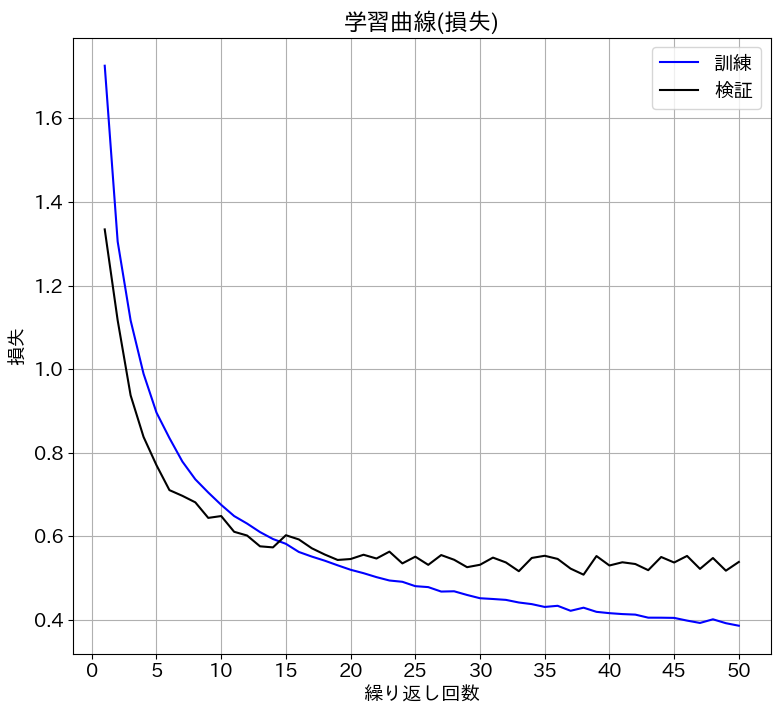

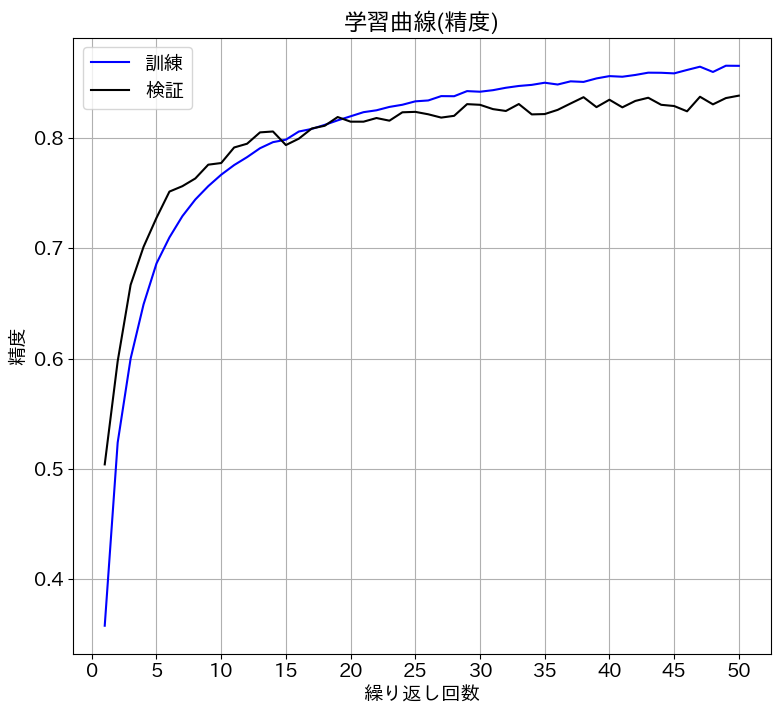

In [48]:
evaluate_history(history)

# 10.9 バッチ正規化

In [49]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
        self.conv2 = nn.Conv2d(32, 32, 3, padding="same")
        self.maxpool = nn.MaxPool2d((2, 2))
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 64, 3, padding="same")
        self.conv5 = nn.Conv2d(64, 128, 3, padding="same")
        self.conv6 = nn.Conv2d(128, 128, 3, padding="same")
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # maxpool を3回かけるので画像の辺の長さが 32 -> 16 -> 8 -> 4 になる
        # チャネル数128 のため、flatten すると4*4*128の特徴量となる
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [50]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [51]:
# 学習
num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.49196 acc: 0.45432 val_loss: 1.10457, val_acc: 0.60420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.12193 acc: 0.60102 val_loss: 0.91727, val_acc: 0.67470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.97766 acc: 0.65792 val_loss: 0.82909, val_acc: 0.70730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.88297 acc: 0.69246 val_loss: 0.76984, val_acc: 0.73530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.81220 acc: 0.71908 val_loss: 0.68247, val_acc: 0.76130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.77523 acc: 0.73518 val_loss: 0.64493, val_acc: 0.77010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.72368 acc: 0.75402 val_loss: 0.61088, val_acc: 0.78560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.68790 acc: 0.76714 val_loss: 0.63076, val_acc: 0.78860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.65568 acc: 0.77774 val_loss: 0.53466, val_acc: 0.81930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.62528 acc: 0.78884 val_loss: 0.52046, val_acc: 0.82290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.60127 acc: 0.79976 val_loss: 0.52493, val_acc: 0.82410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.57767 acc: 0.80470 val_loss: 0.52196, val_acc: 0.82560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54797 acc: 0.81588 val_loss: 0.55059, val_acc: 0.81800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53366 acc: 0.82144 val_loss: 0.51449, val_acc: 0.82930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.51471 acc: 0.82892 val_loss: 0.47370, val_acc: 0.83970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.50009 acc: 0.83130 val_loss: 0.49769, val_acc: 0.83740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.48049 acc: 0.84048 val_loss: 0.46212, val_acc: 0.84590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.46865 acc: 0.84020 val_loss: 0.44929, val_acc: 0.84820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.45305 acc: 0.84660 val_loss: 0.46287, val_acc: 0.84960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.44513 acc: 0.85102 val_loss: 0.46563, val_acc: 0.84790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.43257 acc: 0.85424 val_loss: 0.46596, val_acc: 0.84830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.42307 acc: 0.85734 val_loss: 0.43923, val_acc: 0.85600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.41592 acc: 0.86030 val_loss: 0.45469, val_acc: 0.85540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.39904 acc: 0.86746 val_loss: 0.45623, val_acc: 0.85520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.39301 acc: 0.86782 val_loss: 0.45856, val_acc: 0.85400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.38019 acc: 0.87318 val_loss: 0.41897, val_acc: 0.86510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.37228 acc: 0.87496 val_loss: 0.47807, val_acc: 0.85370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.36474 acc: 0.87856 val_loss: 0.44491, val_acc: 0.85920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.35621 acc: 0.88174 val_loss: 0.43020, val_acc: 0.86220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.35260 acc: 0.88088 val_loss: 0.43368, val_acc: 0.86420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.33901 acc: 0.88636 val_loss: 0.45974, val_acc: 0.85780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.33307 acc: 0.88760 val_loss: 0.43653, val_acc: 0.86300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.32815 acc: 0.88830 val_loss: 0.44002, val_acc: 0.86600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.32104 acc: 0.89306 val_loss: 0.43883, val_acc: 0.86160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.31659 acc: 0.89330 val_loss: 0.43861, val_acc: 0.86460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.30810 acc: 0.89630 val_loss: 0.43865, val_acc: 0.86710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.30764 acc: 0.89602 val_loss: 0.43760, val_acc: 0.86850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.29568 acc: 0.89922 val_loss: 0.43045, val_acc: 0.86890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.29412 acc: 0.89948 val_loss: 0.45279, val_acc: 0.86090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.29270 acc: 0.90078 val_loss: 0.44386, val_acc: 0.86450


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.28815 acc: 0.90218 val_loss: 0.43244, val_acc: 0.86770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.28048 acc: 0.90300 val_loss: 0.43701, val_acc: 0.86860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.27408 acc: 0.90804 val_loss: 0.44436, val_acc: 0.86600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.27669 acc: 0.90584 val_loss: 0.44580, val_acc: 0.87300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.27294 acc: 0.90924 val_loss: 0.44282, val_acc: 0.87230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.26601 acc: 0.90984 val_loss: 0.42093, val_acc: 0.87540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.26149 acc: 0.91076 val_loss: 0.43585, val_acc: 0.87090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.26014 acc: 0.91112 val_loss: 0.43997, val_acc: 0.87040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.25171 acc: 0.91400 val_loss: 0.46628, val_acc: 0.86840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.25592 acc: 0.91414 val_loss: 0.43680, val_acc: 0.87070


初期状態: 損失: 1.10457 精度: 0.60420
最終状態: 損失: 0.43680 精度: 0.87070


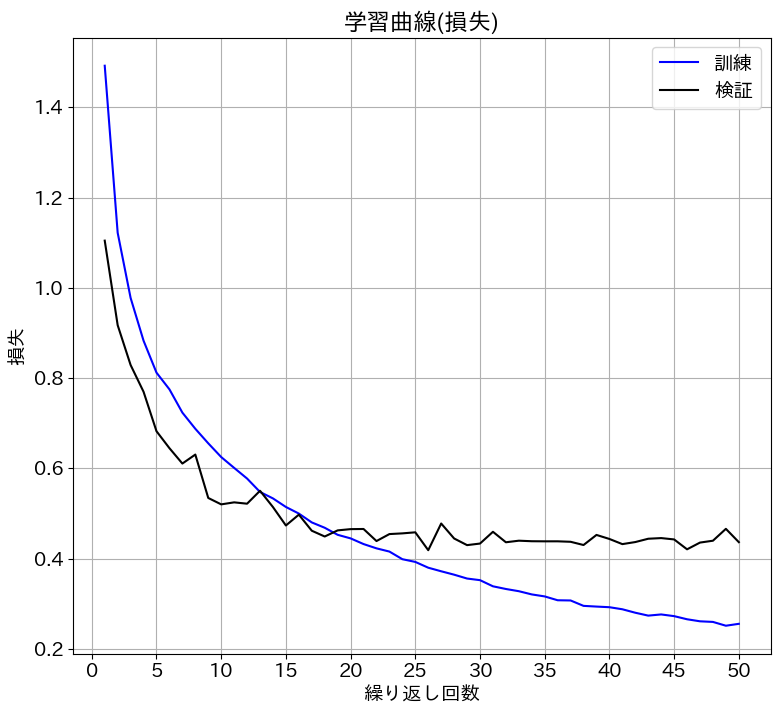

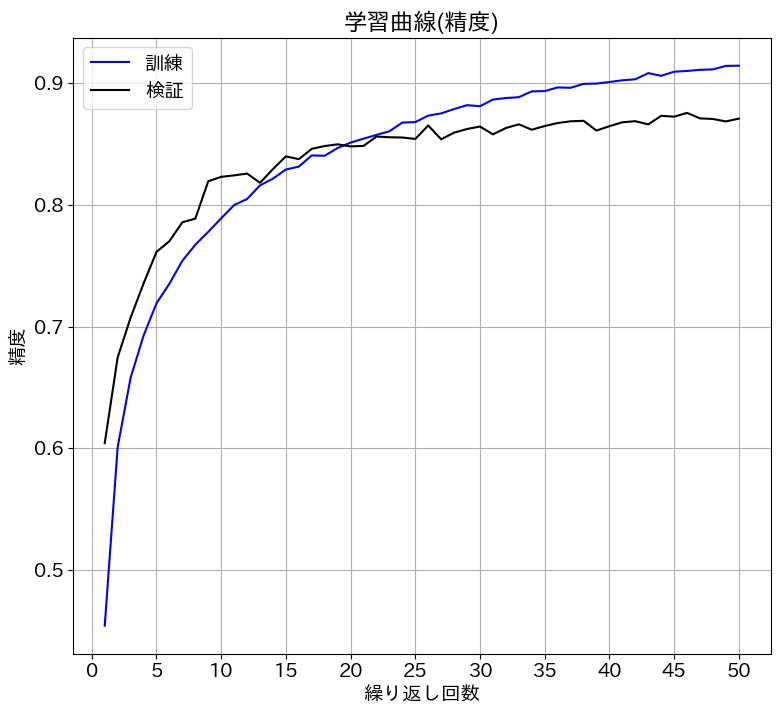

In [52]:
evaluate_history(history)

# 10.10 Data Augmentation

In [53]:
# データ拡張
# 正規化に追加で左右反転と RandomErasing を実施
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # [0, 1] -> [-1, 1]
    transforms.Normalize(0.5, 0.5),
    # scale: range of proportion of erased area against input image.
    # ratio: range of aspect ratio of erased area.
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [54]:
# transform_train を使ってデータセットを定義
train_set2 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform_train,
)

batch_size = 100
train_loader2 = DataLoader(
    train_set2,
    batch_size=batch_size,
    shuffle=True,
)

Files already downloaded and verified


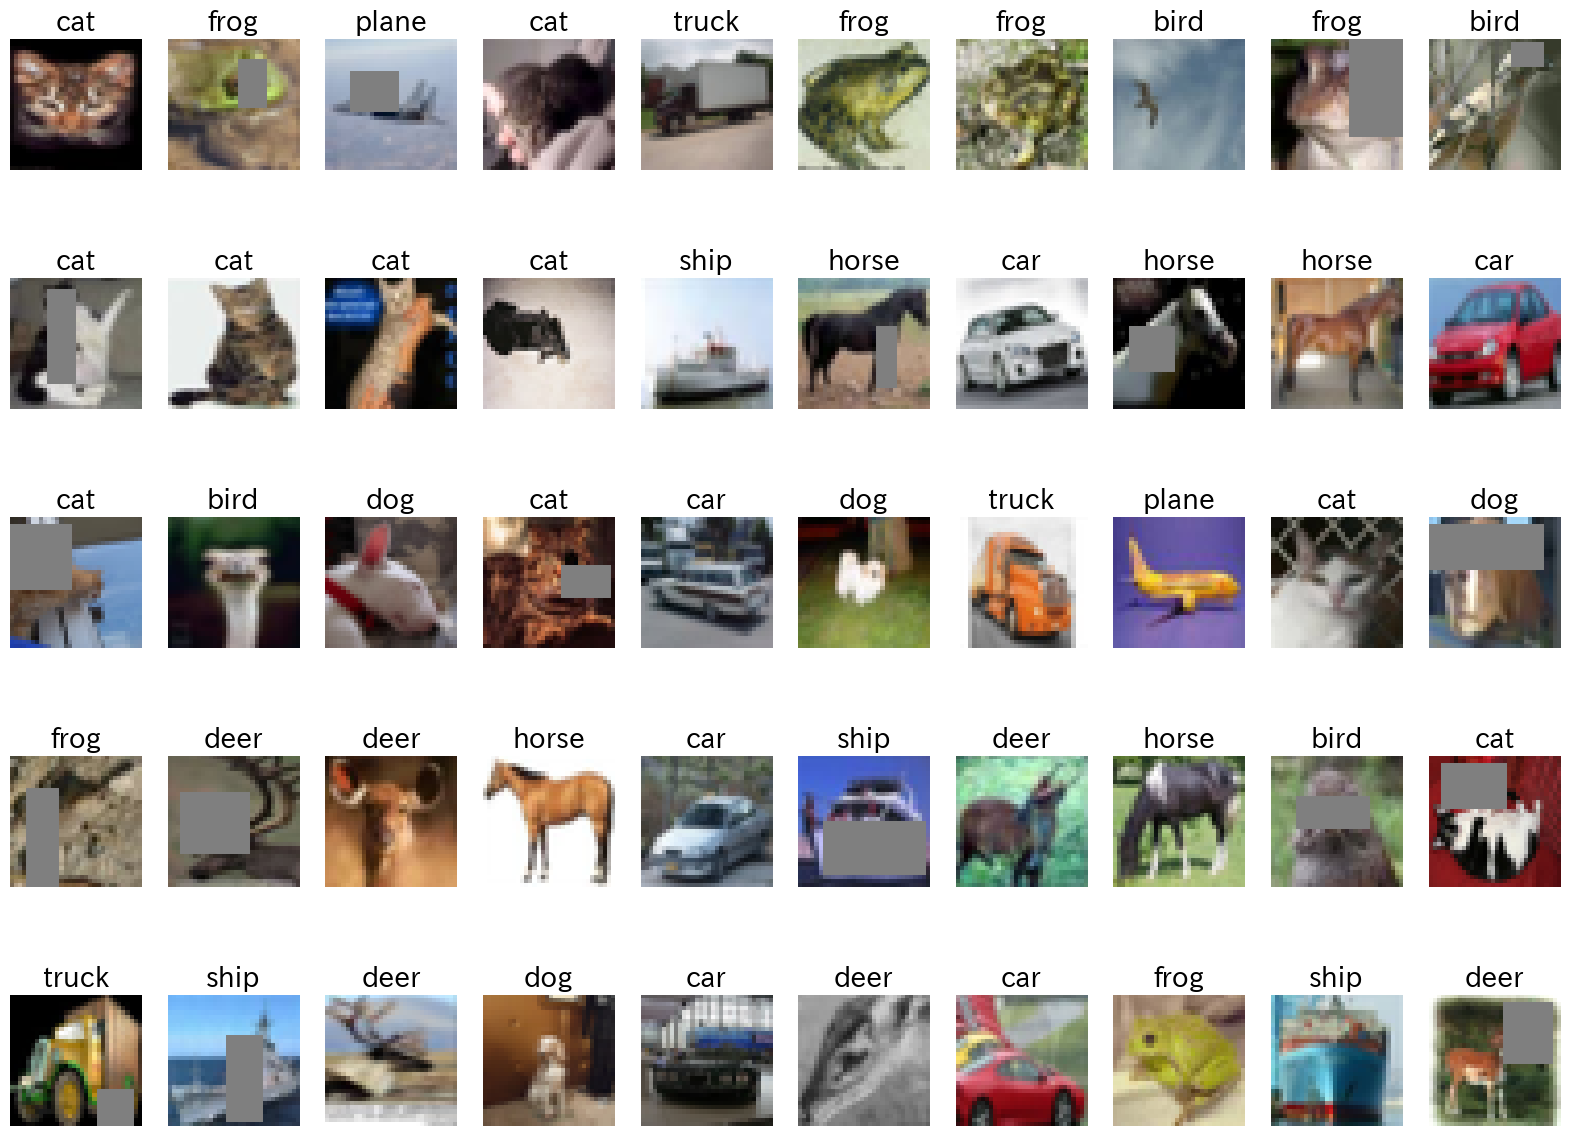

In [55]:
# データ拡張したデータの先頭50を表示

# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch_seed()
show_images_labels(
    train_loader2,
    classes,
    None,
    None,
)

In [56]:
# 乱数の固定化
torch_seed()

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [57]:
# 学習
# 同じモデルでtrain_loader2に変更
num_epochs = 100
history = fit(net, optimizer, criterion, num_epochs, 
        train_loader2, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.60582 acc: 0.40598 val_loss: 1.26948, val_acc: 0.54610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/100], loss: 1.28396 acc: 0.53712 val_loss: 1.16371, val_acc: 0.58820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/100], loss: 1.14715 acc: 0.59284 val_loss: 0.93259, val_acc: 0.65790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/100], loss: 1.06234 acc: 0.62738 val_loss: 0.82820, val_acc: 0.70170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.99715 acc: 0.65292 val_loss: 0.77598, val_acc: 0.72620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.96100 acc: 0.66686 val_loss: 0.72374, val_acc: 0.74200


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.92462 acc: 0.68266 val_loss: 0.70606, val_acc: 0.75210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.88649 acc: 0.69648 val_loss: 0.79446, val_acc: 0.72850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.86108 acc: 0.70468 val_loss: 0.63702, val_acc: 0.77890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.83274 acc: 0.71540 val_loss: 0.61638, val_acc: 0.78440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.81516 acc: 0.72374 val_loss: 0.64474, val_acc: 0.77950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.78989 acc: 0.73312 val_loss: 0.57509, val_acc: 0.80110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.77034 acc: 0.73880 val_loss: 0.55453, val_acc: 0.80880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.75010 acc: 0.74652 val_loss: 0.55413, val_acc: 0.80780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.73019 acc: 0.75554 val_loss: 0.52380, val_acc: 0.82280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.71268 acc: 0.75898 val_loss: 0.53784, val_acc: 0.81540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.70962 acc: 0.76196 val_loss: 0.52104, val_acc: 0.81990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.69571 acc: 0.76784 val_loss: 0.50804, val_acc: 0.82990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.67676 acc: 0.77358 val_loss: 0.51070, val_acc: 0.82430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.66694 acc: 0.77780 val_loss: 0.50407, val_acc: 0.82780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.65033 acc: 0.78088 val_loss: 0.47615, val_acc: 0.83780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.64179 acc: 0.78484 val_loss: 0.47601, val_acc: 0.84210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.62952 acc: 0.78986 val_loss: 0.45780, val_acc: 0.85020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.62735 acc: 0.79072 val_loss: 0.46742, val_acc: 0.84550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.61296 acc: 0.79590 val_loss: 0.48349, val_acc: 0.84130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.60283 acc: 0.79894 val_loss: 0.44438, val_acc: 0.85000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.58989 acc: 0.80300 val_loss: 0.44601, val_acc: 0.85170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.59303 acc: 0.80220 val_loss: 0.46580, val_acc: 0.84410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.58219 acc: 0.80392 val_loss: 0.44331, val_acc: 0.85290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.56640 acc: 0.80990 val_loss: 0.44917, val_acc: 0.85150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.56437 acc: 0.81456 val_loss: 0.45717, val_acc: 0.85110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.55084 acc: 0.81530 val_loss: 0.40995, val_acc: 0.85910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.55003 acc: 0.81364 val_loss: 0.41284, val_acc: 0.86130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.54356 acc: 0.81586 val_loss: 0.43219, val_acc: 0.85630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.53837 acc: 0.81800 val_loss: 0.42587, val_acc: 0.85840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.53439 acc: 0.82180 val_loss: 0.44665, val_acc: 0.85340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.52474 acc: 0.82366 val_loss: 0.40337, val_acc: 0.86400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.52459 acc: 0.82446 val_loss: 0.40051, val_acc: 0.86990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.51964 acc: 0.82368 val_loss: 0.40668, val_acc: 0.86730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.52131 acc: 0.82480 val_loss: 0.41882, val_acc: 0.86300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.51646 acc: 0.82552 val_loss: 0.41692, val_acc: 0.86070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.50968 acc: 0.82918 val_loss: 0.39152, val_acc: 0.87310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.50283 acc: 0.82976 val_loss: 0.42397, val_acc: 0.85940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.50076 acc: 0.83126 val_loss: 0.40358, val_acc: 0.86790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.50004 acc: 0.83218 val_loss: 0.40906, val_acc: 0.86550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.49755 acc: 0.83188 val_loss: 0.38697, val_acc: 0.87060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.48397 acc: 0.83618 val_loss: 0.40653, val_acc: 0.86660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.48398 acc: 0.83678 val_loss: 0.39200, val_acc: 0.87470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.47976 acc: 0.83664 val_loss: 0.39222, val_acc: 0.86910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.47940 acc: 0.83736 val_loss: 0.39289, val_acc: 0.87260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.47367 acc: 0.83866 val_loss: 0.39075, val_acc: 0.87360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.47450 acc: 0.83936 val_loss: 0.39285, val_acc: 0.86900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.46890 acc: 0.84096 val_loss: 0.37777, val_acc: 0.87720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.46128 acc: 0.84486 val_loss: 0.38569, val_acc: 0.87570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.46230 acc: 0.84192 val_loss: 0.38379, val_acc: 0.87400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.46148 acc: 0.84286 val_loss: 0.37633, val_acc: 0.87770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.46315 acc: 0.84448 val_loss: 0.40473, val_acc: 0.87020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.45805 acc: 0.84712 val_loss: 0.38463, val_acc: 0.87670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.45549 acc: 0.84536 val_loss: 0.37468, val_acc: 0.87770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.45694 acc: 0.84568 val_loss: 0.37672, val_acc: 0.87860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.45149 acc: 0.84606 val_loss: 0.38313, val_acc: 0.87430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.45081 acc: 0.84734 val_loss: 0.38858, val_acc: 0.87710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.45003 acc: 0.84680 val_loss: 0.37810, val_acc: 0.88000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.44194 acc: 0.85060 val_loss: 0.36753, val_acc: 0.88320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.43904 acc: 0.85198 val_loss: 0.38173, val_acc: 0.87480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.44237 acc: 0.85092 val_loss: 0.37401, val_acc: 0.87970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.44049 acc: 0.85132 val_loss: 0.39008, val_acc: 0.87540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.43588 acc: 0.84950 val_loss: 0.35887, val_acc: 0.88320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.43574 acc: 0.85232 val_loss: 0.36447, val_acc: 0.88080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.43213 acc: 0.85394 val_loss: 0.38016, val_acc: 0.87910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.42714 acc: 0.85622 val_loss: 0.37054, val_acc: 0.87830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.43063 acc: 0.85476 val_loss: 0.35869, val_acc: 0.88560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.42403 acc: 0.85492 val_loss: 0.36286, val_acc: 0.88240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.42233 acc: 0.85628 val_loss: 0.36865, val_acc: 0.88270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.42385 acc: 0.85622 val_loss: 0.37790, val_acc: 0.88070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.41705 acc: 0.85710 val_loss: 0.35173, val_acc: 0.88730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.42064 acc: 0.85862 val_loss: 0.36042, val_acc: 0.88510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.41420 acc: 0.85982 val_loss: 0.36125, val_acc: 0.88810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.41743 acc: 0.85870 val_loss: 0.36265, val_acc: 0.88410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.41503 acc: 0.85764 val_loss: 0.38126, val_acc: 0.88050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.41472 acc: 0.85800 val_loss: 0.36127, val_acc: 0.88780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.40743 acc: 0.86160 val_loss: 0.36127, val_acc: 0.88040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.41309 acc: 0.86024 val_loss: 0.34917, val_acc: 0.88380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.40757 acc: 0.86010 val_loss: 0.36093, val_acc: 0.88770


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.40597 acc: 0.86234 val_loss: 0.35165, val_acc: 0.88960


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.40301 acc: 0.86268 val_loss: 0.35264, val_acc: 0.88710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.40497 acc: 0.86184 val_loss: 0.35060, val_acc: 0.88860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.40412 acc: 0.86168 val_loss: 0.35503, val_acc: 0.88860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.40087 acc: 0.86232 val_loss: 0.35351, val_acc: 0.88640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.40260 acc: 0.86092 val_loss: 0.36271, val_acc: 0.88650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.40172 acc: 0.86454 val_loss: 0.34654, val_acc: 0.88890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.39575 acc: 0.86484 val_loss: 0.36011, val_acc: 0.88650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.39847 acc: 0.86420 val_loss: 0.35585, val_acc: 0.88720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.40080 acc: 0.86252 val_loss: 0.36082, val_acc: 0.88530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.39287 acc: 0.86578 val_loss: 0.35617, val_acc: 0.88850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.39002 acc: 0.86594 val_loss: 0.35120, val_acc: 0.88810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.39716 acc: 0.86428 val_loss: 0.35562, val_acc: 0.88570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.39113 acc: 0.86530 val_loss: 0.35890, val_acc: 0.88810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.39031 acc: 0.86626 val_loss: 0.34313, val_acc: 0.88970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.38361 acc: 0.87168 val_loss: 0.34972, val_acc: 0.88860


初期状態: 損失: 1.26948 精度: 0.54610
最終状態: 損失: 0.34972 精度: 0.88860


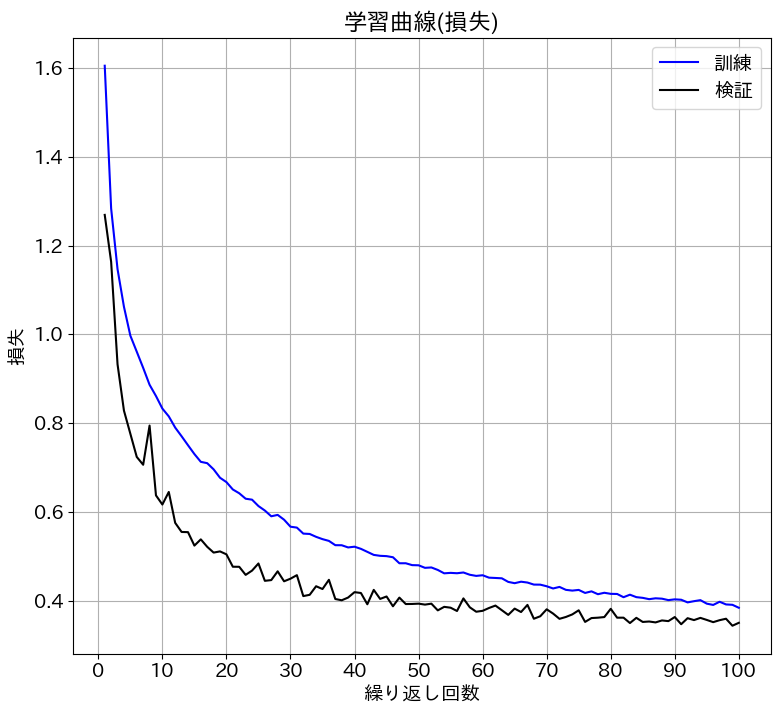

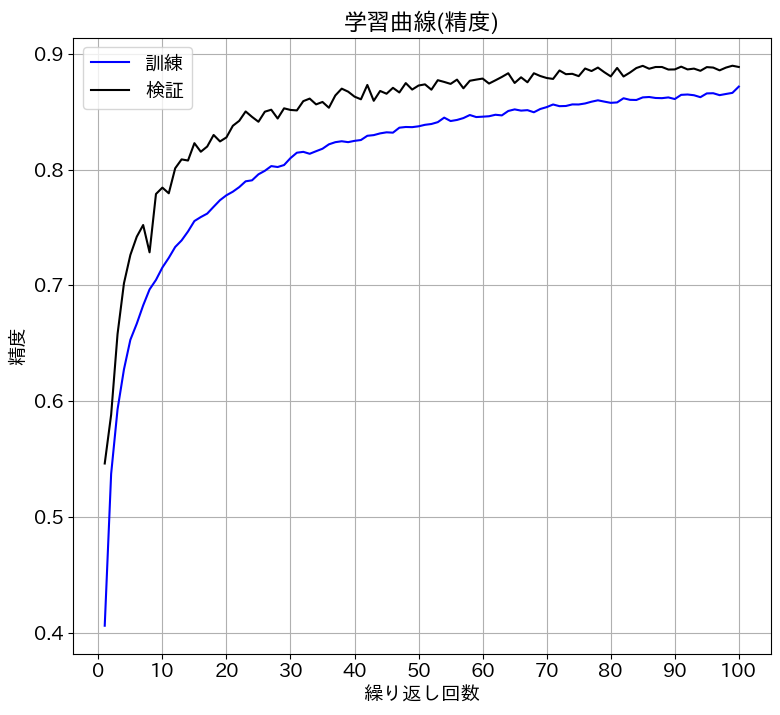

In [58]:
evaluate_history(history)

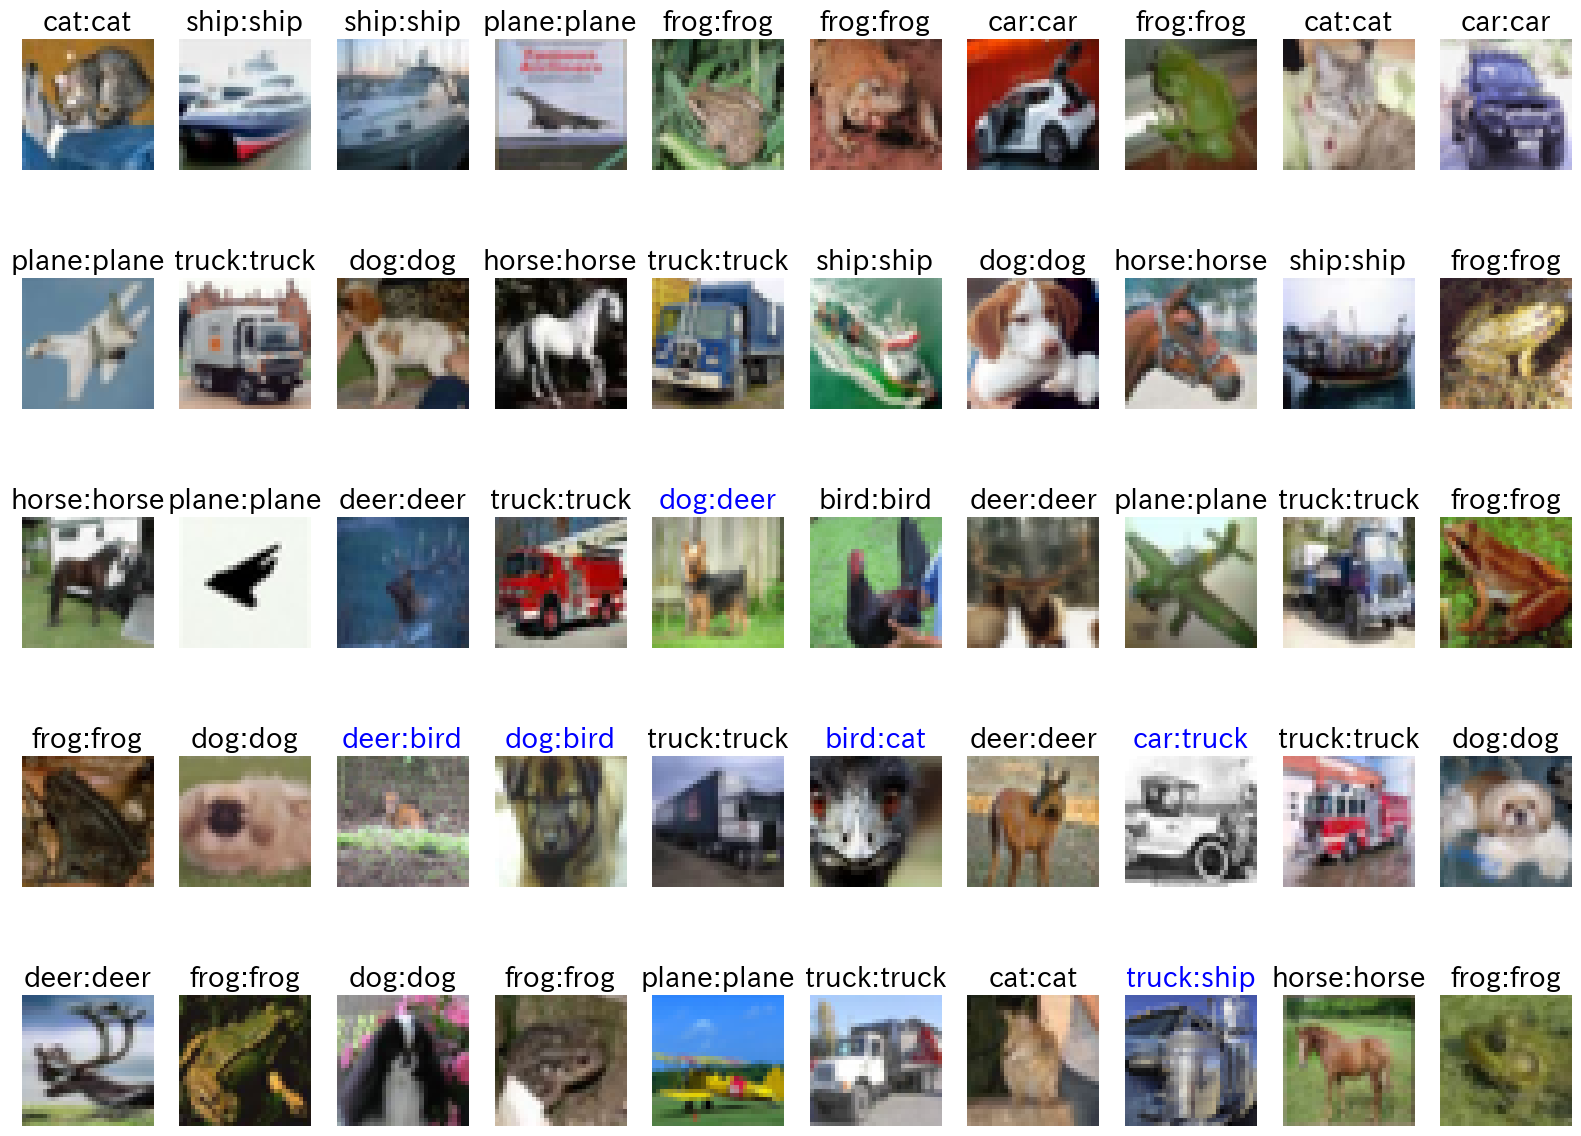

In [59]:
show_images_labels(test_loader, classes, net, device)

In [60]:
# 間違えた37番目のデータ
for images, labels in test_loader:
    break
image = images[37]
label = labels[37]

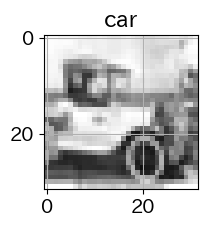

In [62]:
# イメージ表示
plt.figure(figsize=(2,2))
w = image.numpy().copy()
# チャネル軸を最後にする
w2 = np.transpose(w, (1, 2, 0))
# [-1, 1] -> [0, 1]
w3 = (w2 + 1) / 2
plt.title(classes[label])
plt.imshow(w3)
plt.show()

In [63]:
image.shape

torch.Size([3, 32, 32])

In [64]:
# 予測値を取得
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

In [66]:
output

tensor([[ -6.8309,   5.7890,  -9.5707,  -9.3214, -12.4246, -10.0101,  -6.8247,
         -11.6204,  -2.1501,   6.0181]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [67]:
# ラベル別の確率値を表示
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to("cpu").numpy()

In [68]:
probs_np

array([[0.     , 0.44291, 0.     , 0.     , 0.     , 0.     , 0.     ,
        0.     , 0.00016, 0.55693]], dtype=float32)

In [69]:
probs_np = probs_np[0]

In [70]:
names = np.array(classes)

In [74]:
values = np.frompyfunc(lambda x: f"{x:.04f}", 1, 1)(probs_np)

In [75]:
tbl = np.array([names, values]).T

In [76]:
tbl

array([['plane', '0.0000'],
       ['car', '0.4429'],
       ['bird', '0.0000'],
       ['cat', '0.0000'],
       ['deer', '0.0000'],
       ['dog', '0.0000'],
       ['frog', '0.0000'],
       ['horse', '0.0000'],
       ['ship', '0.0002'],
       ['truck', '0.5569']], dtype=object)